# Task 1: Genes
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
# Load libraries
import os
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, mutual_info_score, f1_score, roc_auc_score, silhouette_score, plot_roc_curve, plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from fcmeans import FCM

from tqdm import tqdm

In [2]:
# Configure libraries
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Set location of data directory
data_path = os.path.join("..","Data-PR-As2","Genes")

In [4]:
# Path for saving figures
figure_path = "Figures"
if not os.path.isdir(figure_path):
    os.mkdir(figure_path)

def save_plot(name):
    if name:
        plt.savefig(os.path.join(figure_path, name + ".pdf"), bbox_inches="tight")

In [5]:
# Load dataset (this takes a while)
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df_labels = pd.read_csv(os.path.join(data_path, "labels.csv"))

In [6]:
# Remove first columns as they just contain row names
df = df.iloc[:, 1:]
df_labels = df_labels.iloc[:, 1:]

## Data Analysis

In [7]:
# Dimensions of data
n_observations, n_features = df.shape
print("# observations:",n_observations," # features:", n_features)
classes = df_labels["Class"].unique()
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

# observations: 801  # features: 20531
There are 5 classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [8]:
def plot_class_freq(y, fig_name=None):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    ax.bar_label(ax.containers[0])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    save_plot(fig_name)
    plt.show()

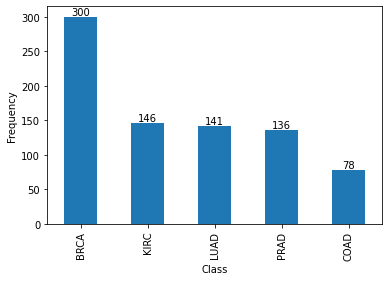

In [9]:
# Inspect frequency of class labels
plot_class_freq(df_labels, fig_name="imbalanced")

Min value: 0.0  Max value: 20.7788287118


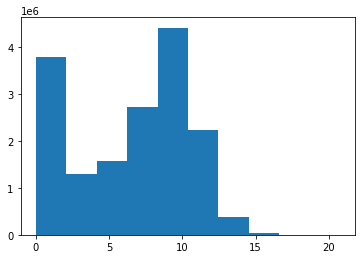

In [10]:
# Distribution of data across all features
df.stack().hist(grid=False)
df_np = df.to_numpy()
print("Min value:", df_np.min(), " Max value:", df_np.max())

In [11]:
print("Are there duplicate rows in the dataset?", any(df.duplicated()))

Are there duplicate rows in the dataset? False


In [12]:
palette = dict(zip(classes, sns.color_palette(n_colors=n_classes)))

def plot_tsne(x, y, fig_name=None, lim=60, palette=palette, title=None, show=True):
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue="Class", palette=palette, data=y)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    if title:
        plt.title(title)
        fig_name = title.replace(" ", "_")
    if show:
        save_plot(fig_name)
        plt.show()
    else:
        return X_tsne

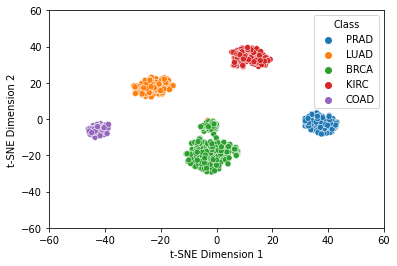

In [13]:
# Visualize multidimensional data
plot_tsne(df, df_labels, fig_name="imbalanced_tsne")

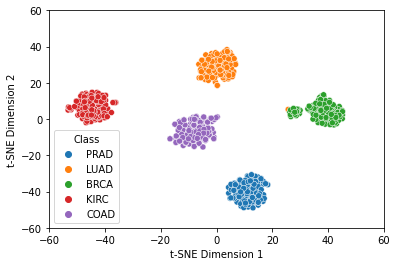

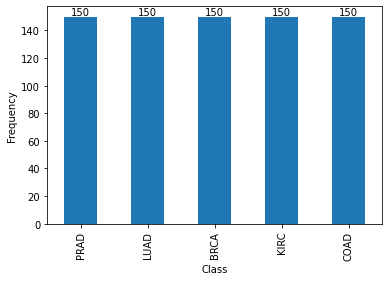

In [14]:
# Balance dataset

# remove 150 from BRCA
prad_idxs = df_labels.index[df_labels["Class"] == "BRCA"]
remove_indices = np.random.choice(prad_idxs, size=150, replace=False)
adjusted_df = df.drop(remove_indices)
adjusted_df_labels = df_labels.drop(remove_indices)

# over sample rest of classes
sm = SMOTE(sampling_strategy="not majority", k_neighbors=5, random_state=RANDOM_STATE)
adjusted_df, adjusted_df_labels = sm.fit_resample(adjusted_df, adjusted_df_labels)

plot_tsne(adjusted_df, adjusted_df_labels, fig_name="balanced_tsne")
plot_class_freq(adjusted_df_labels) # double check

## Feature Selection / Dimension Reduction

In [15]:
# Create hold-out set
X_all, y_all = adjusted_df, adjusted_df_labels
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_all, y_all, test_size=0.2, random_state=RANDOM_STATE)

### PCA

In [16]:
def plot_pca_comp_variance(x, comp, fig_name=None):
    pca = PCA(n_components=comp)
    pca.fit(x)
    plt.plot(list(range(1, comp + 1)), pca.explained_variance_ratio_, "o-", linewidth=2)
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    save_plot(fig_name)
    plt.show()

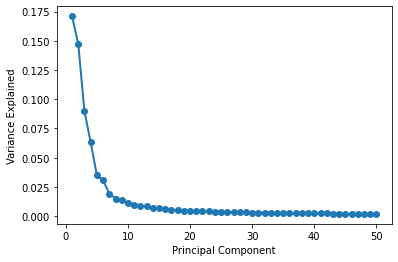

In [18]:
plot_pca_comp_variance(X_train_bal, comp=50, fig_name="scree")

In [22]:
def try_pca(components, x_train, y_train, x_test, y_test, model, normalizer, unsuper):
    scores = []
    
    if normalizer:
        x_train = normalizer.fit_transform(x_train)
        x_test = normalizer.transform(x_test)
    
    for n in tqdm(components):
        pca = PCA(n_components=n, random_state=RANDOM_STATE)
            
        X_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        if unsuper:
            model.fit(X_train_pca)
            y_pred = model.predict(X_train_pca)
            y_test = (y_train.to_numpy()).flatten()
        else:
            model.fit(X_train_pca, y_train)
            y_pred = model.predict(x_test_pca)
        
        score_func = mutual_info_score if unsuper else accuracy_score
        scores.append(score_func(y_test, y_pred))
        
    return scores

def find_best_pca(x, y, model, normalizer, label, color, linestyle, min_comp=2, max_comp=20, split=0.2, unsuper=False):
    
    if unsuper:
        X_train, X_test, y_train, y_test = x, x, y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=RANDOM_STATE) 
    
    components = list(range(min_comp, max_comp + 1))
    scores = try_pca(components, X_train, y_train, X_test, y_test, model, normalizer, unsuper)
    
    best_n_components = np.argmax(scores) + min_comp
    label = f"{label}  (min comp = {best_n_components})"
    plt.plot(components, scores, label=label, color=color, linestyle=linestyle)
    plt.xlabel("Number of Components used")
    plt.ylabel("Mutual Info Score" if unsuper else "Model Accuracy")
    plt.xticks(np.arange(min_comp, max_comp+1, 2.0))
    plt.legend()
    
    return best_n_components

In [23]:
models = [(LogisticRegression(random_state=RANDOM_STATE), "LogReg", "blue"), 
          (GaussianNB(), "NB", "red"),
          (KNeighborsClassifier(n_neighbors=3), "KNN", "orange")
         ]
norms = [(None, "", "solid"), (StandardScaler, "Norm", "dotted")] #, (MinMaxScaler, "MinMax", "dashed")]

100%|███████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


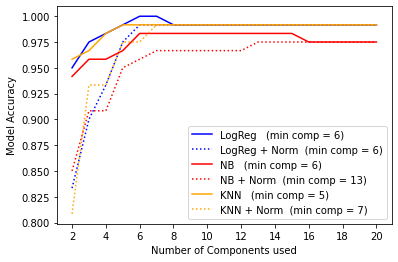

In [24]:
comps = []

for m, m_name, color in models:
    for n, n_name, style in norms:
        normalizer = n() if n else None
        name = m_name + (" + " if n_name else " ") + n_name  
        comps.append(find_best_pca(X_train_bal, y_train_bal, m, normalizer, name, color, style))

save_plot("best_pca")
plt.show()

In [25]:
pca_n_comp_logreg = comps[0]
pca_n_comp_nb = comps[2]
pca_n_comp_knn = comps[4]

### Mutual Information

In [26]:
def own_mutual_info_classif(X, y):
    return mutual_info_classif(X, y, random_state=RANDOM_STATE)

def rank_features(x, y):
    selector = SelectKBest(own_mutual_info_classif, k="all")
    selector.fit(x, y)
    feature_importance = np.flip(np.argsort(selector.scores_))
    return feature_importance

In [27]:
def try_mutual_info(top_n_feat, top_features, x_train, y_train, x_test, y_test, 
                    model, normalizer, unsuper, score_func=accuracy_score):
    scores = []
    
    if normalizer:
        x_train = pd.DataFrame(normalizer.fit_transform(x_train))
        x_test = pd.DataFrame(normalizer.transform(x_test))
    
    for i in tqdm(top_n_feat):
        best_cols = top_features[:i]
                
        reduced_x_train = x_train.iloc[:,best_cols]
        reduced_x_test = x_test.iloc[:,best_cols]
        
        if unsuper:
            x = reduced_x_train.to_numpy()
            model.fit(x)
            y_pred = model.predict(x)
            y_test = (y_train.to_numpy()).flatten()
        else:
            model.fit(reduced_x_train, y_train)
            y_pred = model.predict(reduced_x_test)
        
        score_func = mutual_info_score if unsuper else accuracy_score
        scores.append(score_func(y_test, y_pred))
    
    return scores

def find_best_mutual_info(features_ranked, x, y, model, normalizer, label, color, linestyle, unsuper=False,
                          min_n_feat=2, top_n_feat=20, split=0.2):
    
    if unsuper:
        X_train, X_test, y_train, y_test = x, x, y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=RANDOM_STATE)   
    
    top_n_feat_val = list(range(min_n_feat, top_n_feat + 1))
    scores = try_mutual_info(top_n_feat_val, features_ranked, X_train, y_train, X_test, y_test, model, normalizer, unsuper)
    min_feat = np.argmax(scores) + min_n_feat
    
    plt.plot(top_n_feat_val, scores, label=f"{label}  (min feat = {min_feat})", color=color, linestyle=linestyle)
    plt.xlabel("Number of Top N Features used by Model")
    plt.ylabel("Mutual Info Score" if unsuper else "Model Accuracy")
    plt.xticks(np.arange(min_n_feat, top_n_feat+1, 2.0))
    plt.legend()
    
    return features_ranked[:min_feat]

In [28]:
# This takes a while
features_ranked = rank_features(X_train_bal, y_train_bal)

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 221.61it/s]


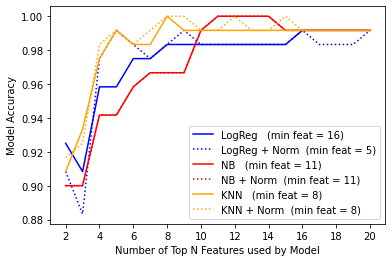

In [29]:
num_feats = []

for m, m_name, color in models:
    for n, n_name, style in norms:
        normalizer = n() if n else None
        name = m_name + (" + " if n_name else " ") + n_name
        num_feats.append(find_best_mutual_info(features_ranked, X_train_bal, y_train_bal, m, normalizer, name, color, style)) 

save_plot("best_feats")
plt.show()

In [30]:
mi_feat_logreg = num_feats[1]
mi_feat_nb = num_feats[2]
mi_feat_knn = num_feats[4]

In [31]:
# Normalization doesn't do anything or makes it worse (for unreduced model)
def test_norm(x, y, normalizer=StandardScaler()):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
    
    X_train_norm = normalizer.fit_transform(X_train)
    X_test_norm = normalizer.transform(X_test)
    
    models = [LogisticRegression(random_state=RANDOM_STATE), GaussianNB(), KNeighborsClassifier(n_neighbors=3)]
    for m in models:
        y_pred = m.fit(X_train, y_train).predict(X_test)
        acc1 = accuracy_score(y_test, y_pred)
        
        y_pred2 = m.fit(X_train_norm, y_train).predict(X_test_norm)
        acc2 = accuracy_score(y_test, y_pred2)
        
        print(m.__class__.__name__, "Not norm: ", acc1, "Norm:", acc2)

test_norm(X_train_bal, y_train_bal)

LogisticRegression Not norm:  0.9916666666666667 Norm: 0.9916666666666667
GaussianNB Not norm:  0.9416666666666667 Norm: 0.7166666666666667
KNeighborsClassifier Not norm:  0.9916666666666667 Norm: 0.9916666666666667


## Classification (K-fold)

In [70]:
def reduce_data(data_manip, X_train, X_test):
    if isinstance(data_manip, PCA):
        X_train = data_manip.fit_transform(X_train)
        X_test = data_manip.transform(X_test)
    elif isinstance(data_manip, np.ndarray):
        X_train = X_train.iloc[:,data_manip]
        X_test = X_test.iloc[:,data_manip]
    return X_train, X_test

def f1_score_multi(y_test, y_pred):
    return f1_score(y_test, y_pred, average="macro")

def cross_val(model, x, y, data_manip=None, normalizer=None, splits=5, metrics=[accuracy_score], unsuper=False):
    times = np.zeros((splits, 2))
    kf = KFold(n_splits=splits)
    scores = np.zeros((splits, len(metrics)))
    
    for i_fold, (train_index, test_index) in enumerate(tqdm(kf.split(x, y), total=splits)):
        X_train, X_test = df.iloc[train_index,:], df.iloc[test_index,:]
        y_train, y_test = df_labels.iloc[train_index,:], np.array(df_labels.iloc[test_index,:]).ravel()
        
        X_train, X_test = reduce_data(data_manip, X_train, X_test)
        
        if normalizer:
            X_train = normalizer.fit_transform(X_train)
            X_test = normalizer.transform(X_test)
        
        start_train = time.time()
        model.fit(X_train, y_train) if not unsuper else model.fit(X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy())
        end_train = time.time()
        
        start_test = time.time()
        y_pred = model.predict(X_test if isinstance(X_test, np.ndarray) else X_test.to_numpy())
        end_test = time.time()
        
        times[i_fold,:] = [end_train - start_train, end_test - start_test]
        
        for i, m in enumerate(metrics):
            scores[i_fold, i] = m(y_test, y_pred)

    times = times.mean(axis=0)
    scores = scores.mean(axis=0)
    
    return times[1], scores[0]

In [71]:
results = {}

test_models = [("LogReg", LogisticRegression(random_state=RANDOM_STATE), pca_n_comp_logreg, mi_feat_logreg, StandardScaler()),
               ("NB", GaussianNB(), pca_n_comp_nb, mi_feat_nb, None),
               ("KNN", KNeighborsClassifier(n_neighbors=3), pca_n_comp_knn, mi_feat_knn, None)
              ]

for m in test_models:
    results[m[0]] = cross_val(m[1], X_train_bal, y_train_bal)
    results[m[0] + " + PCA"] = cross_val(m[1], X_train_bal, y_train_bal, PCA(n_components=m[2], random_state=RANDOM_STATE))
    results[m[0] + " + MI"] = cross_val(m[1], X_train_bal, y_train_bal, m[3], m[4])

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 24.47it/s]


In [73]:
def bar_plot(index, log=False):
    arr = np.array(list(map(list, results.values())))[:,index]
    if log:
        print(arr)
        arr = np.abs(np.log(arr))
    plt.bar(results.keys(), arr)
    plt.xticks(rotation=65)
    plt.xlabel("Classifier")
    return arr

[1.02406025e-02 1.25217438e-04 8.86917114e-05 3.66560936e-02
 3.18002701e-04 2.73895264e-04 2.08288002e-01 4.06279564e-03
 3.26871872e-03]


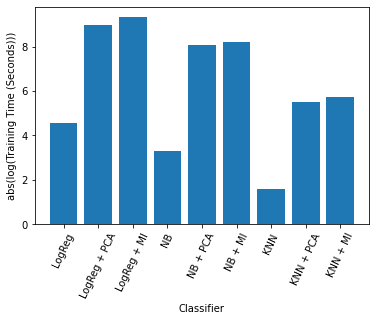

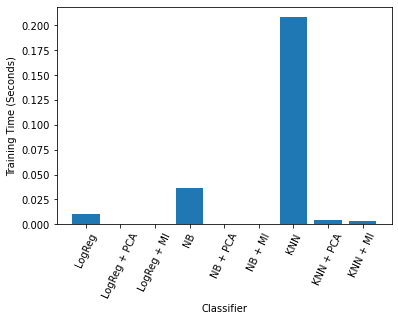

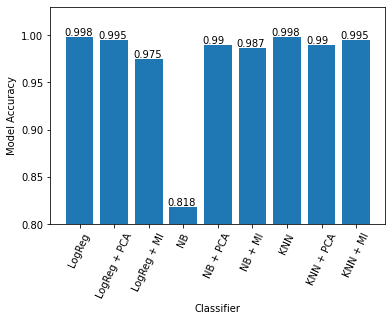

In [74]:
bar_plot(0, log=True)
plt.ylabel("abs(log(Training Time (Seconds)))")
save_plot("time_compare_log")
plt.show()

bar_plot(0, log=False)
plt.ylabel("Training Time (Seconds)")
save_plot("time_compare_std")
plt.show()

y = bar_plot(1)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(y):
    plt.text(xlocs[i] - 0.45, v + 0.001, str(round(v,3)))
plt.ylim(0.8, 1.03)
plt.ylabel("Model Accuracy")
save_plot("acc_compare")
plt.show()

## Grid Search

In [42]:
n_folds = 5

In [43]:
# param_knn = {'n_neighbors':[1, 3, 5, 7], 'weights':('uniform', 'weights'), 'p': [1, 2], 'n_jobs': [-1], 'algorithm': ('ball_tree','kd_tree','brute')}
# gs_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=n_folds, scoring='accuracy')
# gs_knn.fit(X_train_bal, y_train_bal)

In [48]:
param_logReg = {'LogisticRegression__penalty': ['l1', 'l2'],
                'LogisticRegression__C': [0.1, 1, 10], 
                'LogisticRegression__solver': ['lbfgs', 'newton-cg']}
pipe = Pipeline([('PCA', PCA(n_components=pca_n_comp_logreg, random_state=RANDOM_STATE)), 
                 ('LogisticRegression', LogisticRegression(random_state=RANDOM_STATE))])
gs_logReg = GridSearchCV(estimator=pipe, param_grid=param_logReg, cv=n_folds, scoring='accuracy')
gs_logReg.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA',
                                        PCA(n_components=6, random_state=42)),
                                       ('LogisticRegression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'LogisticRegression__C': [0.1, 1, 10],
                         'LogisticRegression__penalty': ['l1', 'l2'],
                         'LogisticRegression__solver': ['lbfgs', 'newton-cg']},
             scoring='accuracy')

In [50]:
# grid search is completely pointless as all combinations lead to 1
r = pd.DataFrame(gs_logReg.cv_results_).dropna()
print(len(r[r.split0_test_score == 1.0]) / len(r))

1.0


In [77]:
def final_cross_val(x, y, model, n_folds2, show=True):
    kf = KFold(n_splits=n_folds2)
    cross_knn = []

    for i_fold, (train_index, test_index) in enumerate(tqdm(kf.split(x, y), total=n_folds2)):
        X_train, X_test = df.iloc[train_index,:], df.iloc[test_index,:]
        y_train, y_test = df_labels.iloc[train_index,:], np.array(df_labels.iloc[test_index,:]).ravel()

        y_pred = model.fit(X_train, y_train).predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        cross_knn.append(acc_score)

        if show and acc_score < 1.0:
            print("Finding and plotting miss-classified point")
            plot_confusion_matrix(model, X_test, y_test)
            save_plot("conf_matrix" + str(n_folds2))
            plt.show()
            diff = [i for i in range(len(X_test)) if y_pred[i] != y_test[i]]
            print("row(s):", diff)
            y_test = df_labels.iloc[test_index,:]
            print(df.iloc[diff, 0])
            points = plot_tsne(X_test, y_test, show=False, lim=12)
            plt.plot(points[diff,0], points[diff,1], 'ro', color="black")
            save_plot("miss_classified_point")
            plt.show()

    print(cross_knn)
    print("Mean: ", np.mean(cross_knn))
    print("Std: ", np.std(cross_knn))

 14%|██████▍                                      | 1/7 [00:01<00:06,  1.02s/it]

Finding and plotting miss-classified point


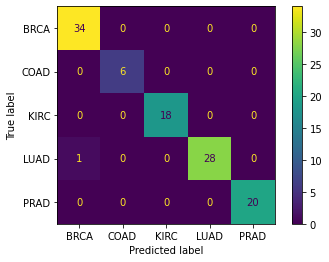

row(s): [21]
21    0.0
Name: gene_0, dtype: float64


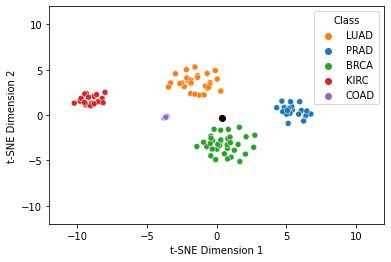

100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.15s/it]

[1.0, 0.9906542056074766, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean:  0.9986648865153539
Std:  0.0032703467860923613


In [78]:
# 7-Fold cross validation
n_folds2 = 7

best_params = {}
for key, value in gs_logReg.best_params_.items():
    best_params[key.replace('LogisticRegression__', "")] = value
    
model = Pipeline([('PCA', PCA(n_components=pca_n_comp_logreg, random_state=RANDOM_STATE)), 
                 ('LogisticRegression', LogisticRegression(**best_params, random_state=RANDOM_STATE))])
final_cross_val(X_all, y_all, model, n_folds2)

In [80]:
# Leave-one-out cross validation (Takes a while)
n_folds2 = X_all.shape[0]

final_cross_val(X_all, y_all, pipe, n_folds2, show=False)

100%|█████████████████████████████████████████| 750/750 [14:12<00:00,  1.14s/it]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [81]:
model = pipe
model.fit(X_train_bal, y_train_bal)
final_acc_testsplit = accuracy_score(y_test_bal, model.predict(X_test_bal))
print(final_acc_testsplit)

1.0


## Clustering

100%|███████████████████████████████████████████| 19/19 [00:20<00:00,  1.10s/it]


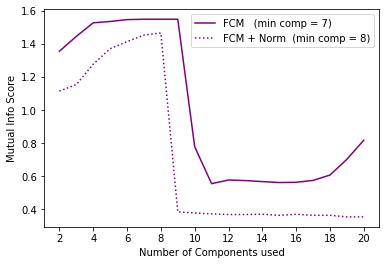

In [83]:
X_cluster, y_cluster = X_all, y_all

color = "purple"
model = FCM(n_clusters=5, random_state=RANDOM_STATE)
m_name = "FCM"
comps2 = []

for n, n_name, style in norms:
    normalizer = n() if n else None
    name = m_name + (" + " if n_name else " ") + n_name  
    comps2.append(find_best_pca(X_cluster, y_cluster, model, normalizer, name, color, style, unsuper=True))

best_comp_cls = comps2[0]
save_plot("best_pca_cluster")

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 104.73it/s]


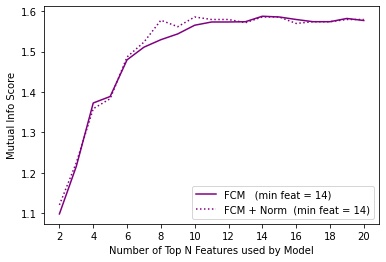

In [84]:
num_feats2 = []

for n, n_name, style in norms:
    normalizer = n() if n else None
    name = m_name + (" + " if n_name else " ") + n_name
    num_feats2.append(find_best_mutual_info(features_ranked, X_cluster, y_cluster, model, normalizer, name, color, style, unsuper=True))
    
best_feats_cls = num_feats2[0]
save_plot("best_feat_cluster")

In [85]:
# on original dataset
train_data = X_cluster.to_numpy()
model.fit(train_data)
y_pred_org = model.predict(train_data)

In [86]:
# mutual information
train_data_mi = X_cluster.iloc[:,best_feats_cls].to_numpy()
model.fit(train_data_mi)
y_pred_mi = model.predict(train_data_mi)

In [87]:
# PCA
pca = PCA(n_components=best_comp_cls)
train_data_pca = pca.fit_transform(X_cluster)
model.fit(train_data_pca)
y_pred_pca = model.predict(train_data_pca)

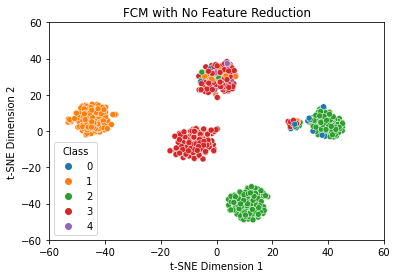

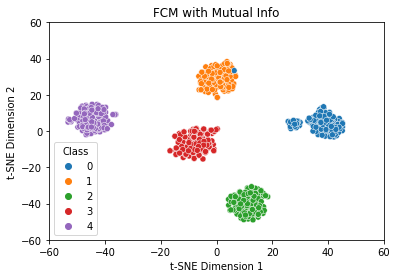

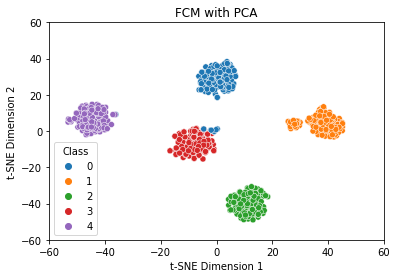

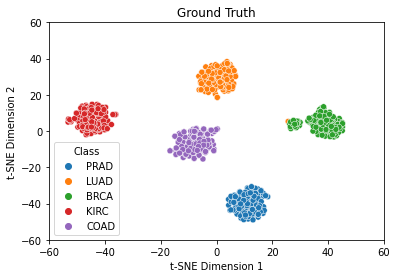

In [88]:
palette2 = dict(zip(list(range(0,n_classes)), sns.color_palette(n_colors=n_classes)))

lim=60
plot_tsne(X_cluster, pd.DataFrame({"Class":y_pred_org}), lim=lim, palette=palette2, title="FCM with No Feature Reduction")
plot_tsne(X_cluster, pd.DataFrame({"Class":y_pred_mi}), lim=lim, palette=palette2, title="FCM with Mutual Info")
plot_tsne(X_cluster, pd.DataFrame({"Class":y_pred_pca}), lim=lim, palette=palette2, title="FCM with PCA")
plot_tsne(X_cluster, y_cluster, lim=lim, title="Ground Truth")

In [89]:
preds = [(y_pred_org, train_data, ""), (y_pred_pca, train_data_pca, "with PCA"), (y_pred_mi, train_data_mi, "with MI")]
y_test = y_cluster.to_numpy().flatten()

results_cls = {}

for y_pred, x_test, name in preds:
    #print(silhouette_score(x_test, y_pred))
    results_cls["FCM " + name] = mutual_info_score(y_test, y_pred)

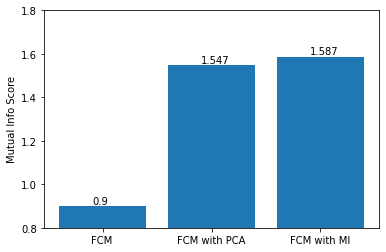

In [90]:
plt.bar(results_cls.keys(), results_cls.values())
plt.ylim(0.8, 1.8)
xlocs, xlabs = plt.xticks()
for i, v in enumerate(results_cls.values()):
    plt.text(xlocs[i] - 0.1, v + 0.01, str(round(v,3)))
plt.ylabel("Mutual Info Score")
save_plot("final_cluster_results")
plt.show()